In [1]:
# let's perform PCA on the drifter, ocean surface, and wind velocity vector fields

In [57]:
# dependencies
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from tqdm import tqdm
import netCDF4 as nc

import scipy.interpolate as sci_int
import scipy.stats as sci_stats
import geopandas as gpd

from scipy.ndimage import gaussian_filter,  generic_filter

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [3]:
os.chdir('/dat1/openonic/Drifters') # directory

In [4]:
# set plotting text size parameters
plt.rcParams.update({
    'axes.titlesize': 30,
    'axes.labelsize': 24, 
    'xtick.labelsize': 18,  
    'ytick.labelsize': 18,  
    'legend.fontsize': 18, 
    'figure.titlesize': 28})

In [5]:
# load wind CSV
u_winds = pd.read_csv('avg_u_winds.csv')
v_winds = pd.read_csv('avg_v_winds.csv')

# load probability of beaching data
beach = pd.read_csv('undrogued_beach.csv')
unbeach = pd.read_csv('undrogued_unbeach.csv')

In [6]:
# load surface ocean current velocities
os.chdir('/home/openonic/global-drifter-program/')
circ = nc.Dataset('data/circulation.nc')
u_ocn = np.array(circ.variables['u'])[0]
v_ocn = np.array(circ.variables['v'])[0]

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

In [7]:
# perform wind preprocessing
def df_aggregation_by_factor_8(df):
    # keep original df unaffected
    working_df = df.copy()

    # initialize row mean:
    row_means = []
    
    # for each odd row    
    for i in tqdm(range(0, len(working_df), 2)):

        # initialize column mean:
        col_means = []
        
        # for each odd col
        for j in range(0, len(working_df.columns), 2):  

            # get 3x3 matrix around current grid cell
            matrix = working_df.iloc[i-1:i+2, j-1:j+2].values
            
            # get mean of matrix
            matrix_mean = matrix.mean()
            
            col_means.append(matrix_mean)
            
        row_means.append(col_means)
        
    result_df = pd.DataFrame(row_means)
    
    return result_df

u_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(u_winds.iloc[:-1,:]))
v_winds = df_aggregation_by_factor_8(df_aggregation_by_factor_8(v_winds.iloc[:-1,:]))

  0%|          | 0/360 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice.
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 180/180 [00:06<00:00, 26.35it/s]


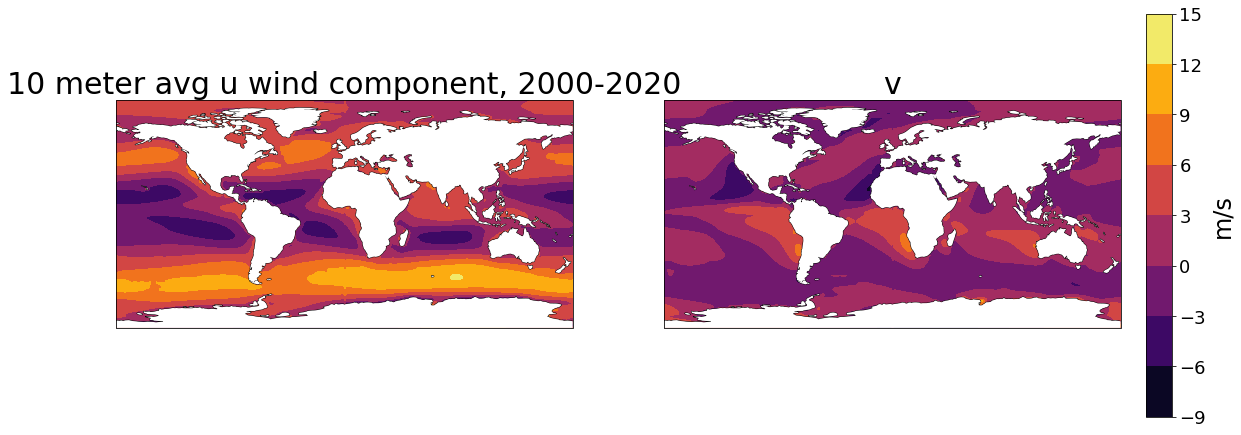

In [8]:
# flip vertically
u_winds = u_winds.iloc[::-1]
v_winds = v_winds.iloc[::-1]

# shift 180 degrees lon
u_winds =  pd.concat([u_winds.iloc[:, u_winds.shape[1] // 2:], u_winds.iloc[:, :u_winds.shape[1] // 2]], axis=1)
v_winds =  pd.concat([v_winds.iloc[:, v_winds.shape[1] // 2:], v_winds.iloc[:, :v_winds.shape[1] // 2]], axis=1)

# we have a problem: at 0 lon, there's a column of missing data
# this comes from the original data's projection. Let's fill in
# this missing data by interpolating between 0 and 180
u_winds[0] = u_winds[[1, 180]].mean(axis=1)
v_winds[0] = v_winds[[1, 180]].mean(axis=1)

# define desired rows and desired cols
desired_rows = 360
desired_cols = 180
# define lat and lon
lats_wind = np.linspace(-90,90,desired_cols)
lons_wind = np.linspace(-180, 180, desired_rows)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons_wind, lats_wind, u_winds, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('10 meter avg u wind component, 2000-2020')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Plot the v-component of wind
ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im2 = ax2.contourf(lons_wind, lats_wind, v_winds, cmap='inferno', transform=ccrs.PlateCarree())
ax2.set_title('v')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax2.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax2.add_feature(land_feature)

# Create a single colorbar for both plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im2, cax=cbar_ax, label='m/s')

# Adjust layout
plt.subplots_adjust(wspace=0.2, right=0.9)  # wspace for width space, right to make space for colorbar

# Show the plot
plt.show()

In [9]:
# perform ocean preprocessing
u_circ = df_aggregation_by_factor_8(df_aggregation_by_factor_8(pd.DataFrame(u_ocn).iloc[:-1,:]))
v_circ = df_aggregation_by_factor_8(df_aggregation_by_factor_8(pd.DataFrame(v_ocn).iloc[:-1,:]))

smoothed_u_ocn = pd.DataFrame(u_circ)
smoothed_v_ocn = pd.DataFrame(v_circ)

smoothed_u_ocn[0] = smoothed_u_ocn[[1, 719]].mean(axis=1)
smoothed_v_ocn[0] = smoothed_v_ocn[[1, 719]].mean(axis=1)

  0%|          | 0/720 [00:00<?, ?it/s]/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice.
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 360/360 [00:50<00:00,  7.17it/s]


In [21]:
# downscale again to match other dfs
u_ocn = smoothed_u_ocn.values.reshape(180, 2, 360, 2).mean(axis=(1, 3))
v_ocn = smoothed_v_ocn.values.reshape(180, 2, 360, 2).mean(axis=(1, 3))

In [22]:
# define desired rows and desired cols
desired_rows = 360
desired_cols = 180
# define lat and lon
lats_ocn = np.linspace(-90,90,desired_cols)
lons_ocn = np.linspace(-180, 180, desired_rows)

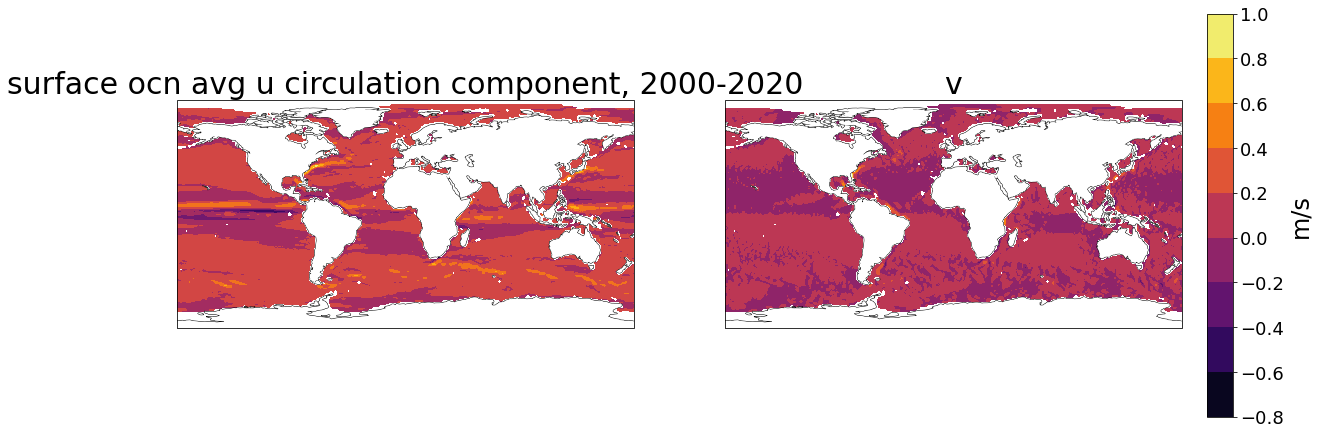

In [23]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),
                               subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

# Plot the u-component of wind
ax1.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im1 = ax1.contourf(lons_ocn, lats_ocn, u_ocn, cmap='inferno', transform=ccrs.PlateCarree())
ax1.set_title('surface ocn avg u circulation component, 2000-2020')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

ax1.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax1.add_feature(land_feature)

# Plot the v-component of wind
ax2.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())
im2 = ax2.contourf(lons_ocn, lats_ocn, v_ocn, cmap='inferno', transform=ccrs.PlateCarree())
ax2.set_title('v')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')

ax2.coastlines(color = 'black')
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                            edgecolor='none', facecolor='white')
ax2.add_feature(land_feature)

# Create a single colorbar for both plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
fig.colorbar(im2, cax=cbar_ax, label='m/s')

# Adjust layout
plt.subplots_adjust(wspace=0.2, right=0.9)  # wspace for width space, right to make space for colorbar

# Show the plot
plt.show()

In [26]:
# let's prepare drifter velocity now
beach_undrogued_lats = np.array(beach['lat'])
beach_undrogued_longs = np.array(beach['lon'])

# get unbeached lats and lons
unbeach_undrogued_lats = np.array(unbeach['lat'])
unbeach_undrogued_longs = np.array(unbeach['lon'])

In [28]:
# bin u and v components of velocity
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

beach_velocity_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    beach_undrogued_longs,beach_undrogued_lats,values=(beach['ve'],beach['vn']),
    statistic = 'mean', bins = [lon_bins,lat_bins])

unbeach_velocity_stat, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(
    unbeach_undrogued_longs,unbeach_undrogued_lats,values=(unbeach['ve'],unbeach['vn']),
    statistic = 'mean', bins = [lon_bins,lat_bins])

In [82]:
# we need to remove polar latitudes as these regions have much less drifter velocity data
u_beach_velocity = beach_velocity_stat[0].T[20:-20]
v_beach_velocity = beach_velocity_stat[1].T[20:-20]

u_unbeach_velocity = unbeach_velocity_stat[0].T[20:-20]
v_unbeach_velocity = unbeach_velocity_stat[1].T[20:-20]

u_ocn_ = u_ocn[20:-20]
v_ocn_ = v_ocn[20:-20]

u_winds_ = u_winds[20:-20]
v_winds_ = v_winds[20:-20]

In [83]:
# let's standardize the data by removing the mean and scaling to variance
vector_fields = [u_beach_velocity, v_beach_velocity, 
                 #u_unbeach_velocity, v_unbeach_velocity,
                 np.array(u_ocn_), np.array(v_ocn_), np.array(u_winds_), np.array(v_winds_)]

# flatten vector fields for scaling
vector_fields_flattened = np.column_stack([field.flatten() for field in vector_fields])

# use mean to fill in NaNs
imputer = SimpleImputer(strategy = 'mean')
vector_fields_imputed = imputer.fit_transform(vector_fields_flattened)

# scale
scaler = StandardScaler()
scaled_vector_fields = scaler.fit_transform(vector_fields_imputed)

In [84]:
# perform PCA
pca = PCA(n_components=4)  # You can choose the number of principal components
PCs = pca.fit_transform(scaled_vector_fields)

# # df for PCs
columns = [f'PC{i}' for i in range(1, pca.n_components_ + 1)]
PC_df = pd.DataFrame(data=PCs, columns = columns)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance)
print("Sum of explained variance ratios:", np.sum(explained_variance))

Explained variance ratio: [0.37210431 0.22977617 0.14625389 0.10871307]
Sum of explained variance ratios: 0.8568474453289943


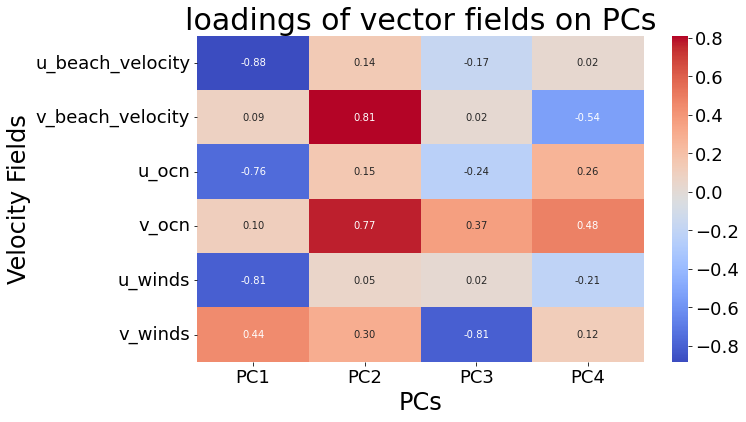

In [85]:
# calculating loadings, i.e., how much each velocity field impacts the PCs
vector_field_names = ['u_beach_velocity', 'v_beach_velocity', 
                      'u_ocn', 'v_ocn', 'u_winds', 'v_winds']
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, columns=columns, index=vector_field_names)

# visualize
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('loadings of vector fields on PCs')
plt.xlabel('PCs')
plt.ylabel('Velocity Fields')
plt.show()

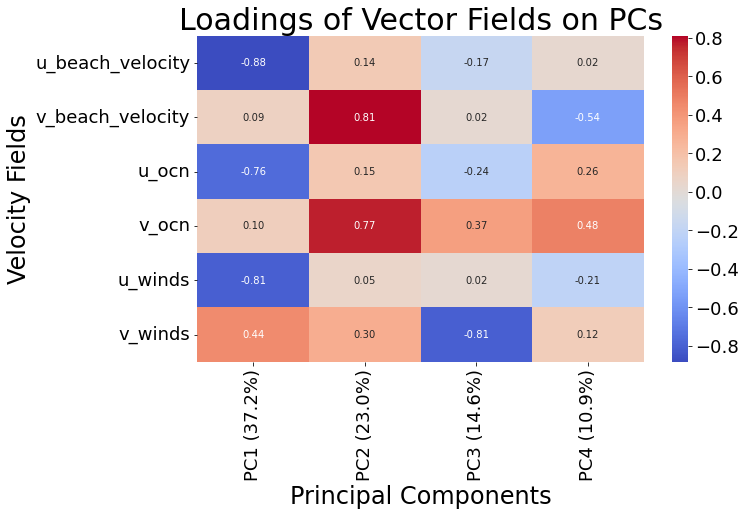

In [105]:
explained_variance_percent = pca.explained_variance_ratio_ * 100  # if not already in percent

# Create labels with explained variance included
pc_labels = [f"PC{i+1} ({explained_variance_percent[i]:.1f}%)" for i in range(len(explained_variance_percent))]

# Calculate loadings
vector_field_names = ['u_beach_velocity', 'v_beach_velocity', 
                      'u_ocn', 'v_ocn', 'u_winds', 'v_winds']
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, columns=pc_labels, index=vector_field_names)

# Visualize with explained variance in x-axis labels
plt.figure(figsize=(10, 6))
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Loadings of Vector Fields on PCs')
plt.xlabel('Principal Components')
plt.ylabel('Velocity Fields')
plt.show()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0.5, 0, 'u_beach_velocity'),
  Text(1.5, 0, 'v_beach_velocity'),
  Text(2.5, 0, 'u_ocn'),
  Text(3.5, 0, 'v_ocn'),
  Text(4.5, 0, 'u_winds'),
  Text(5.5, 0, 'v_winds')])

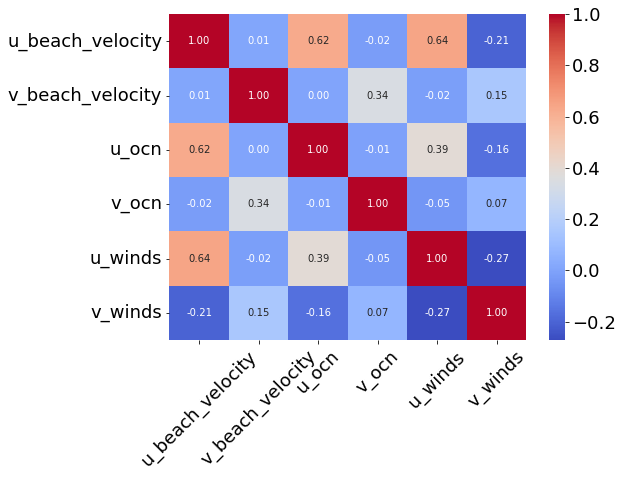

In [104]:
correlation_matrix = pd.DataFrame(scaled_vector_fields, columns=vector_field_names).corr()

#mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, mask = None, cmap="coolwarm", fmt=".2f", cbar=True)
plt.xticks(rotation=45)